# MNIS Model Eğitme
* `!pip install --upgrade azureml-sdk azureml-widgets` ile gereklilikleri yükle

In [1]:
import azureml.core
from azureml.core import Workspace

print('SDK versiyonu', azureml.core.VERSION)

SDK versiyonu 1.27.0


## Workspace oluşturma ve bağlanma

### Workspace Oluşturma

### Var olan Workspsacee Yakalama

In [2]:
# Workspace yakalayalım.

#1. yöntem get ile
#ws = Workspace.get(name='kisemlws', subscription_id='XXXX-5b5a-XXX-9be1-XXXXX', resource_group='krg')

#2. yöntem config dosyası ile (Config dosyasını workspace overview sayfasından indirebilirsin.)
ws = Workspace.from_config()

print(f'Workspace: {ws.name} | Rg: {ws.resource_group} | Location: {ws.location}')

Workspace: kisemlws | Rg: krg | Location: northeurope


## MNIST Dataset İndirme ve Uncompress

In [3]:
#data ve script için klasorleri oluşturalım.
import os

verikumesi_klasoru='./mnist_data'
komut_klasoru='./mnist_script'

#!mkdir ile de oluşturabilirdik.
os.makedirs(verikumesi_klasoru, exist_ok = True)
os.makedirs(komut_klasoru, exist_ok = True)

### İndirme

In [4]:
import urllib.request as rq

train_images_path=verikumesi_klasoru+'/train-images.gz'
train_labels_path=verikumesi_klasoru+'/train-labels.gz'
test_images_path=verikumesi_klasoru+'/test-images.gz'
test_labels_path=verikumesi_klasoru+'/test-labels.gz'

if not os.path.isfile(train_images_path):
    rq.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',filename=train_images_path)
if not os.path.isfile(train_labels_path):
    rq.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',filename=train_labels_path)
if not os.path.isfile(test_images_path):
    rq.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=test_images_path)
if not os.path.isfile(test_labels_path):
    rq.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=test_labels_path)

### Uncompress

In [22]:
#aşağıdaki fonksiyonu yardimci.py dosyası olarak yazar.

In [8]:
%%writefile $komut_klasoru/yardimci.py

import gzip
import numpy as np
import struct

# load compressed MNIST gz files and return numpy arrays
def veri_uncompress(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res

Overwriting ./mnist_script/yardimci.py


In [5]:
#module bulamazsa notebook yeniden başlatmak gerekli.
from mnist_script.yardimci import veri_uncompress

X_train = veri_uncompress(train_images_path, False) / 255.0
y_train = veri_uncompress(train_labels_path, True).reshape(-1)

X_test = veri_uncompress(test_images_path, False) / 255.0
y_test = veri_uncompress(test_labels_path, True).reshape(-1)

In [6]:
# (satır,kolon)
print(f"Train : {X_train.shape} | Test : {X_test.shape}")

Train : (60000, 784) | Test : (10000, 784)


In [66]:
# 0 beyaz 1 siyah
#X_train[0]

### Bazı örnekler görüntüleyelim

In [7]:
import numpy as np

np.random.permutation(10) #10'a kadar 10 tane rastgele sayı

array([1, 9, 5, 6, 4, 8, 2, 3, 0, 7])

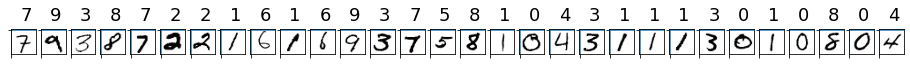

In [8]:
import numpy as np
import matplotlib.pyplot as plt

ornek_adedi=30

plt.figure(figsize = (16, 6)) #daha büyük çizim alanı
subplot_sayac=0

for i in np.random.permutation(X_train.shape[0])[:ornek_adedi]: #dizi olarak ornek adedi kadar rastgele al.
    
    #alt plot oluşturalım.
    subplot_sayac=subplot_sayac+1
    plt.subplot(1, ornek_adedi, subplot_sayac)
    plt.axhline('')
    plt.axvline('')
    
    plt.text(x=10,y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)

#plt.show()

## Notebook'un Olduğu Makinede Eğitim

In [9]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1/0.8, solver="liblinear")
clf.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 233 ms, total: 1min 40s
Wall time: 3min 13s


LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_test_tahmin = clf.predict(X_test)
print("Accuracy: ",np.average(y_test_tahmin == y_test))

Accuracy:  0.9205


## Azureml Compute Oluşturma ve Yakalama

In [11]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#yoksa oluşsun varsa yakalasın.
compute_adi='ktr'

try:
    egitim_compute=ComputeTarget(workspace=ws, name=compute_adi)
    print("Böyle bir compute mevcut. Çalışmaya devam edebilirsin.")
except ComputeTargetException:
    #Bir hata alırsa bu compute oluşsun #dir(AmlCompute)
    try:
        compute_ayari=AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2',min_nodes=1,max_nodes=1)
        egitim_compute=ComputeTarget.create(workspace=ws, name=compute_adi, provisioning_configuration=compute_ayari)
        
        egitim_compute.wait_for_completion(show_output=True) #bekle
        
    except Exception as ex:
        print('Compute oluşturulurken bir hata ile karşılaşıldı.', ex)

Böyle bir compute mevcut. Çalışmaya devam edebilirsin.


In [12]:
#Compute durumuna bakalım.
compute_durum=egitim_compute.get_status()
#print(egitim_compute.get_status().serialize()) #tüm bilgiler.

print(f'Durum: {compute_durum.allocation_state} | Aktif Node: {compute_durum.current_node_count}')

Durum: Steady | Aktif Node: 1


## Azurml Compute Üzerinde Eğitim
* Eğitim için gerekli tüm scriptleri bir araya getirelim
* ScriptRunConfig oluşturalım.
* Experiment oluşturup ScriptRunConfig nesnesini submit edelim
* run nesnesi üzerinden gelişmeleri takip edelim

### Eğitim scriptini oluşturalım

In [13]:
%%writefile $komut_klasoru/egitim.py

import argparse
import os
import numpy as np
import joblib

#from mnist_script.yardimci import veri_uncompress #localde test ederken
from yardimci import veri_uncompress #script klasorunda hepsi bir arada olacak.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,accuracy_score

from azureml.core import Run

#dışarıdan bu dosyaya arguman gönderebilelim. 
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
#argumanları pars edelim.
args = parser.parse_args()

#data_folder argumanından gelen yolu kullanacağız.
#azure_veri_klasoru = os.path.join(args.data_folder, 'mnist_data')

train_images_path=args.data_folder+'/train-images.gz'
train_labels_path=args.data_folder+'/train-labels.gz'
test_images_path =args.data_folder+'/test-images.gz'
test_labels_path =args.data_folder+'/test-labels.gz'

#veriyi seçelim.
X_train = veri_uncompress(train_images_path, False) / 255.0
y_train = veri_uncompress(train_labels_path, True).reshape(-1)

X_test = veri_uncompress(test_images_path, False) / 255.0
y_test = veri_uncompress(test_labels_path, True).reshape(-1)

#eğitelim
#args.reg dışarıdan arguman ile gelecek ve 0.8 göndereceğiz.
clf = LogisticRegression(C=1/args.reg, solver="liblinear")
clf.fit(X_train, y_train)

#tahmin edelim.
y_test_tahmin = clf.predict(X_test)

#metrikler
prec=precision_score(y_test,y_test_tahmin,average='macro')
rec=recall_score(y_test, y_test_tahmin, average='macro')
acc= accuracy_score(y_test, y_test_tahmin,normalize=True)
print("Precision: {}\nRecall: {}\nAccuracy: {}".format(prec,rec,acc))

#run yakalyalım ve loglara bazı bilgileri yazalım.
run = Run.get_context()

run.log('regularization rate', np.float(args.reg))
run.log('Precision',prec)
run.log('Recall',rec)
run.log('accuracy', acc)

#eğitilen modeli kaydedelim.
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=clf, filename='outputs/sklearn_mnist_trained_model.pkl')

Writing ./mnist_script/egitim.py


In [14]:
!ls mnist_script

__pycache__  egitim.py	yardimci.py


### Verileri aynı klasore alalım

In [19]:
#klasoru komple kopyaladık.
!cp -r mnist_data $komut_klasoru 

In [20]:
!ls mnist_script/

__pycache__  egitim.py	mnist_data  yardimci.py


### Environment, ScriptRunConfig, Experiment ve Run oluşturalım

In [21]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies

#### Environment

In [22]:
#kullanılan paketleri belirtelim.
mnist_env_sdk = Environment("mnist-env")

paketler = CondaDependencies.create(pip_packages=['scikit-learn','azureml-defaults'])

mnist_env_sdk.python.conda_dependencies = paketler

#### ScriptRunConfig

In [23]:
script_config = ScriptRunConfig(source_directory=komut_klasoru,
                                script='egitim.py',
                                arguments = ['--regularization', 0.8,
                                             '--data-folder','mnist_data'],
                                environment= mnist_env_sdk,
                                compute_target=egitim_compute #belirtilmezse local compute kullanılır.
                               ) 

#### Experiment ve Run

In [24]:
exp = Experiment(workspace=ws, name='mnist_training_experiment_sdk')

In [35]:
#!rm -rf /home/azureuser/.azureml/locks/azureml_conda_lock

In [25]:
run = exp.submit(config=script_config)

In [26]:
from azureml.widgets import RunDetails

#widget ile ilerleyişi görelim
RunDetails(run).show()

#run tamamlanana kadar beklesi
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mnist_training_experiment_sdk_1621703399_9393db32',
 'target': 'ktr',
 'status': 'Completed',
 'startTimeUtc': '2021-05-22T17:10:10.014957Z',
 'endTimeUtc': '2021-05-22T17:12:08.526615Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '47e35afd-5c4f-4d82-b64a-be265488d37d',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'egitim.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--regularization', '0.8', '--data-folder', 'mnist_data'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'ktr',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'mnist-env',
   've

In [27]:
print(run.get_metrics()) #metrikleri script içerisinde biz yazdırmıştık.

{'regularization rate': 0.8, 'Precision': 0.9194692064187955, 'Recall': 0.9193295826591571, 'accuracy': 0.9205}


## Eğitilen Modeli Kaydedelim

In [28]:
print(run.get_file_names()) #outputs/sklearn_mnist_trained_model.pkl

['azureml-logs/55_azureml-execution-tvmps_b970f9180b756880a8bbc23c6843239375569083aea524cc8ae60be2b272e91f_d.txt', 'azureml-logs/65_job_prep-tvmps_b970f9180b756880a8bbc23c6843239375569083aea524cc8ae60be2b272e91f_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_b970f9180b756880a8bbc23c6843239375569083aea524cc8ae60be2b272e91f_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/107_azureml.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'outputs/sklearn_mnist_trained_model.pkl']


In [31]:
#register model
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_trained_model.pkl')

print(model.name, model.id, model.version, sep = '\t')

sklearn_mnist	sklearn_mnist:1	1


In [33]:
# register model 
from azureml.core.model import Model

#model=Model(ws, 'sklearn_mnist')
model.download(target_dir='./trained_model', exist_ok=True)

#doğrulayalım
os.stat('./trained_model/sklearn_mnist_trained_model.pkl')

os.stat_result(st_mode=33279, st_ino=15726613879242883072, st_dev=52, st_nlink=1, st_uid=0, st_gid=0, st_size=63700, st_atime=1621703862, st_mtime=1621703956, st_ctime=1621703956)